<a id='top'></a>

------

CSCI E-82 Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Section 9: Saturday 2 November 10am EDT

----------


Image classification with Convolutional Neural Networks CNN
================

- [Introduction - Loading and processing the data](#Intro)


- [Building a Convolutional Neural Network](#CNNs)
- [Architecture based on LeNet-5](#LeNet)
- [Adding capacity to the network](#five-layer)
- [Less capacity, but with batch normalization](#happy-house)
- [Adding dropout](#dropout)
- [AlexNet architecture](#AlexNet)
- [Data augmentation](#data-augmentation)
-------


![Machine Learning](https://imgs.xkcd.com/comics/machine_learning.png) 

[Some rights reserved -- xkcd.com](https://xkcd.com/license.html)

---   
- Step 0 -     
=================

Preliminaries - loading libraries and styles
---------------

---

In [1]:
import sys
print(sys.version)

3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

/Users/pmw/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0
2.1.6-tf


In [3]:
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

print("Tensorflow is installed and is version: ",  tf.__version__)
print("Keras is installed and is version: ", tf.keras.__version__)

Tensorflow is installed and is version:  1.12.0
Keras is installed and is version:  2.1.6-tf


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import time
import shutil
import sys
import tarfile
from IPython.display import display, Image


from keras import layers
from keras import models
from keras import optimizers
from keras.callbacks import TensorBoard
#from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
#from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
#from keras.models import Model 
#from keras.optimizers import Adam,RMSprop,SGD
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import TensorBoard

from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_data_format('channels_last')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

print("Tensorflow is installed and is version: ",  tf.__version__)
print("Keras is installed and is version: ", tf.keras.__version__)

Tensorflow is installed and is version:  1.12.0
Keras is installed and is version:  2.1.6-tf


Using TensorFlow backend.


#### *The next cell is some code to get both training and vaildation accuracy scores on TensorBoard, we will see later*

In [5]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs/{}'.format(time()), **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

#### *The next two cells are just formatting for the Jupyter (centered, large fonts) and charts in matplotlib - no need to worry about them*

In [6]:
## Markdown CSS
from IPython.core.display import HTML
HTML("""
<style>

div.cell { 
    margin-top:1em;
    margin-bottom:1em;
}

div.text_cell_render h1 {
    font-size: 1.6em;
    line-height:1.2em;
    text-align:center;
}

div.text_cell_render h2 {
margin-bottom: -0.2em;
}

table tbody tr td:first-child, 
table tbody tr th:first-child, 
table thead tr th:first-child, 
table tbody tr td:nth-child(4), 
table thead tr th:nth-child(4) {
    background-color: #edf4e8;
}

div.text_cell_render { 
    font-family: 'Garamond';
    font-size:1.3em;
    line-height:1.3em;
    padding-left:3em;
    padding-right:3em;
}

div#notebook-container    { width: 95%; }
div#menubar-container     { width: 65%; }
div#maintoolbar-container { width: 99%; }

</style>
""")

In [7]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

### *Important* notes and reading / webpage references:

An online reference for the background main ideas about Deep Learning is the [UFLDL Tutorial](http://ufldl.stanford.edu/tutorial/) from Stanford. The Stanford course [CS231N](http://cs231n.stanford.edu/) is a great online background reference on CCNs for Image Recognition, as is the supervised learning material for the Machine Learning course [CS229](http://cs229.stanford.edu/). Sorry for all the Stanford references, but the material there is really good.

I have three recent books that are good references.  The first is a book that is also available free online [Deep Learning, Goodfellow et al.](http://www.deeplearningbook.org/).  The other two are more practical O'Reilly Books: from the course reading list [Hands-on Machine Learning with Sci-kit Learn & Tensorflow](http://proquest.safaribooksonline.com.ezp-prod1.hul.harvard.edu/book/programming/9781491962282) and the second is [The Fundamentals of Deep Learning](http://proquest.safaribooksonline.com.ezp-prod1.hul.harvard.edu/book/programming/machine-learning/9781491925607).  Both are available on Harvard Library's group user Safari Proquest on Hollis (the links go to the books, if you have access).  There is also [Getting started with TensorFlow](http://proquest.safaribooksonline.com.ezp-prod1.hul.harvard.edu/book/programming/machine-learning/9781786468574) available on Proquest through Hollis.

Lastly, and most recent, Chollet's book on [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) has great examples using Keras, and the [notebooks on GitHub](https://github.com/fchollet/deep-learning-with-python-notebooks) provide all the code. I have taken from a couple of these for the Section.

**Note about Backpropagation** If you have the time, there is a presentation by Andrej Karpathy in Stanford's CS231N on [You Tube](https://www.youtube.com/watch?v=59Hbtz7XgjM) that is probably the best explanation in terms of walking you through it. 

#### Please have a look at these links, and the others that follow in the Notebook, if you are looking for pointers to tutorials and examples.

<a id='Intro'></a>

---   
- Step 1 -     
=================

Introduction - Loading and processing the data
---------------
[back to top](#top)

---



While deep learning networks perform much better than other classification methods for images, in recent years, deep learning on images is mostly done using Convolutional Neural Networks (CNN), rather than deep stacks of layers with dense matrix multiplications with varying weights. As we saw in Lecture, CNNs because they exploit the structure of the image and can therefore share weights, allow deeper networks with less parameters. 

How does this work? - the CNN learns about entities in the data - e.g. parts of the images: such as edges, or patches of similarly colored pixels, or entire images of cats' heads, etc.  - and it exploits these 'statistical invariants' to share the parameters - the weights - and to learn them jointly and only once across inputs. Things that don't change over time and/or space are ubiquitous. For images, CNNs perform better than multilayer dense networks, with less parameters. In text classification, the same reasoning leads to embeddings and Recurrent Neural Networks (RNNs).  


Before going into CNNs, we need to load up and prepare the data - we want to get 64x64x3 matrices, which we will call the image's input feature map. 


We will use the Kaggle cats vs. dogs dataset that was made available by Kaggle.com as a  competition back in 2013. There are two advantages:
- it is quite old, even going back to before CNN were all over the leaderboards. But that also means that since then there is has been a lots of code and kernels written that you can find if you want to extend what we do in this notebook
- it is a manageable size binary classification dataset that has already been cleaned. The original [dataset is from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765), and you can play with that too if you want, but there are some buggy JPGs and missing files. 

I will leave you to download the dataset at: https://www.kaggle.com/c/dogs-vs-cats/data - you need to log into your Kaggle account to get the data.  Unzip the zip file into a directory named `all` in the same directory as this notebook.


The next part is largely from the [Notebook 5.2](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb) of Chollet's notebooks on GitHub from Deep Learning with Python.

In [8]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = 'data/all/train'

# Directories for our training,
directories = []

# The directory where we will
# store our smaller dataset
base_dir = 'data/cats_and_dogs_small'
directories.append(base_dir)

# validation and test splits
train_dir = os.path.join(base_dir, 'train')
directories.append(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
directories.append(validation_dir)

test_dir = os.path.join(base_dir, 'test')
directories.append(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
directories.append(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
directories.append(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
directories.append(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
directories.append(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
directories.append(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
directories.append(test_dogs_dir)

# if they have not already been created
for dir in directories: 
    os.mkdir(dir)

In [9]:
# Copy first 8000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(8000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)

# Copy next 2000 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(8000, 10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
    
# Copy next 2000 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(10000, 12000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
    
# Copy first 8000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(8000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
    
# Copy next 2000 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(8000, 10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
    
# Copy next 2000 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(10000, 12000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)

Let's check how many images there are in each directory of the split (train/validation/test):

In [10]:
for dir in directories[4:]:
    print("\nImages in " + dir + ":" + str(len(os.listdir(dir))))


Images in data/cats_and_dogs_small/train/cats:8000

Images in data/cats_and_dogs_small/train/dogs:8000

Images in data/cats_and_dogs_small/validation/cats:2000

Images in data/cats_and_dogs_small/validation/dogs:2000

Images in data/cats_and_dogs_small/test/cats:2000

Images in data/cats_and_dogs_small/test/dogs:2000


So we have indeed 16000 training images, and then 4000 validation images and 4000 test images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

### `keras.preprocessing.image`  to load the data into the network

We want to feed floating point tensors into our network, preferably in batches. We have unzipped the data into a folder as JPEG files, for which we want Keras to do the heavy lifting:

- Read the picture files.
- Decode the JPEG content to RBG grids of pixels.
- Convert these into floating point tensors.
- Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values)
- resize to a common size, not to big to make the example need too much computation


The class `ImageDataGenerator` is part of the preprocessing module, and it is a front-end to [Python generators](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) which are a really cool and easy to use thing in Python.


In [11]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 64x64
        target_size=(64, 64),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 64x64 RGB images (shape `(32, 64, 64, 3)`) and binary 
labels (shape `(32,)`). 32 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [12]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)


Let's take a look at a small sample of the images and their labels in full colour, to see what we are dealing with.

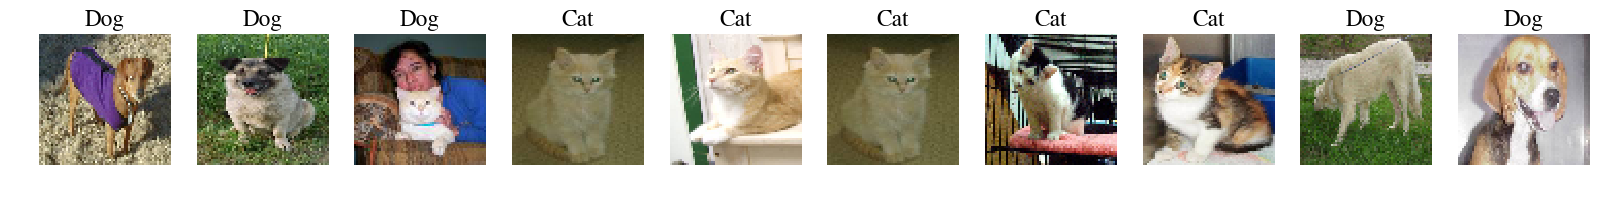

In [13]:
def plot_strip(data, labels):
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    f, ax = plt.subplots(nrows=1, ncols=10)

    for i, j in enumerate(np.random.randint(0,labels.shape[0], size=10)):
        ax[i].axis('off')
        ax[i].set_title(['Cat','Dog'][int(labels[j])], loc='center')
        ax[i].imshow(data[j,:,:], cmap='gray')

        
plot_strip(data_batch, labels_batch)

<a id='CNNs'></a>

---
- Step 2 -
============
Building a Convolutional Neural Net
---------

The first CNN architecture that we will try to build is described at the TensorFlow website  [Build a CNN MNIST Classifier](https://www.tensorflow.org/tutorials/estimators/cnn). It will be a small network with two convolutional layers, followed by one fully connected layer and then the output layer. With the depth of this model, it will run fine on the CPU. We'll look at more elaborate architectures below that you can experiment with. Most production CNNs run on GPUs because they require more computation power. 

In addition to the books mentioned above, there are also web books: Michael A. Nielsen, [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap6.html) and Goodfellow-et-al [Deep Learning](http://www.deeplearningbook.org/). 

As mentioned in Lecture There is also [Colah's blog](http://colah.github.io/) that explains convolutions and has some impressive visualizations. 

If you want to experiment hands-on with convolutions, then head to this [Image Kernels](http://setosa.io/ev/image-kernels/) webpage, where you can play with adjusting the convolutional kernel and see the impact on an image.

You can also do this on your computer, if you download [the GIMP](https://www.gimp.org/downloads/) (if you don't already have it), load up some of your favourite images, and then go to Filters $\rightarrow$ Generic $\rightarrow$ Convolution Matrix.  
[Here](https://docs.gimp.org/2.6/en/plug-in-convmatrix.html) are some examples.

[back to top](#top)

---

![Models](ScreenModels.png)

### First choices to make in a CNN
* convolution kernel dimensions: the patch size (e.g. 5x5)
* stride length: 1, 2, something else
* the padding, SAME or VALID
* pooling: average or max pooling, pooling size  


To make the CNN, we will use the tools provided in the Keras API, in particular `Models` and `Layers`. We could do everything in the lower level functions in TensorFlow, but Keras lets us get up and running quickly, and  provides some great helpers. Like the preprocessing tools that we have just seen.  

The main layer we need is for the convolution itself, the CNN  will be a stack of alternated [```Conv2D```](https://keras.io/layers/convolutional/#conv2d) layers (with relu activation) . The function takes a input as specified in the model definition (we'll see in a minute), but generally this is going to be a 4D input tensor, and the number of filters, their size, stride and padding, as well as the activation function are all specified as parameters.  

The second function is the pooling function, either [```MaxPooling2D```](https://keras.io/layers/pooling/#maxpooling2d) or [```AveragePooling2D```](https://keras.io/layers/pooling/#averagepooling2d). These functions take as input the output from the `Conv2D` layer, generally a 4D input tensor, along with the pooling size, the stride and the padding specified as parameters. As with SciKit Learn functions, you can also not specify some things and you will get the default, or drop the parameter names and just put the values.

We will use a [```Flatten```](https://keras.io/layers/core/#flatten) function which does exactly what the name suggests, before passing the data to the   [```Dense```](https://keras.io/layers/core/#dense) function which is *"just your regular densely-connected NN layer"* and takes as parameters the input size and the number of neurons of the layer. 

An important point is the last parameter to the `Conv2D` and `MaxPooling2D` functions **data_format**. This specifies either "channels_last" or  "channels_first", which is the ordering of the dimensions in the inputs. From the Keras documentation:

*"channels_last" corresponds to inputs with shape  (batch, height, width, channels) while  "channels_first" corresponds to inputs with shape (batch, channels, height, width). It defaults to the  image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".*

Another important thing to know is that you can specify this in when you load the backend (look above in the input statements). This can also be specified as 'tf'  ordering ("channels_last") which is the native TensorFlow ordering, or 'th'  ordering ("channels_first") which is the native Theano ordering.   

**If you get really strange results or errors from Keras, then make sure that you are giving the model the data in the format that you are reading it in. Check how the data format is specified.**

To be clear about what we are doing, here is an image; the source is the "Hands on Machine Learning" book by Geron. 

![Fmaps](ScreenFmaps.png)

<a id='LeNet'></a>

---   


Architecture based on LeNet-5
---------------

[back to top](#top)

---

The architecture of the LeNet-5 model is perhaps the most well-known. It is a simple example to start of with. We won't do average pooling, and we will use the (better) cross-entropy function for the loss, not the one used in the LeNet paper with Euclidean distances and what is labeled Gaussian connections.

Here are some images; the source is the paper and the "Hands on Machine Learning" book by Geron. 

![LeNet2](ScreenLeNet2.png)

![LeNet1](ScreenLeNet1.png)

## Building the first network


Following the  [Build a CNN MNIST Classifier](https://www.tensorflow.org/tutorials/estimators/cnn) example, our first network will have two convolutional layers, a small stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers, followed by one fully connected layer and then the output layer.

- Convolutional Layer #1: Applies 32 5x5 filters (extracting 5x5-pixel subregions), with ReLU activation function
- Pooling Layer #1: Performs max pooling with a 2x2 filter and stride of 2 (which specifies that pooled regions do not overlap)
- Convolutional Layer #2: Applies 64 5x5 filters, with ReLU activation function
- Pooling Layer #2: Again, performs max pooling with a 2x2 filter and stride of 2
- Dense Layer #1: 1,024 neurons, with dropout regularization rate of 0.4 (probability of 0.4 that any given element will be dropped during training)
- Dense Layer #2 (Logits Layer): Output layer with 1 neuron (or if one-hot encoder one for each target class 0–1).


We start from our input images of size 64 x 64. The pre-processing downsamples to get these dimensions, and it is a choice that we make based a tradeoff between the performance of the network and the computation/memory constraints that we have on our machine. 64 x 64 images are still visibly distinct to the human eye. We end up with feature maps of size 7x7 right before the `Flatten` layer.

As with most CNNs, the depth of the feature maps is progressively increased in the network (from 32 to 64), while the size of the feature maps is decreased from 64x64 to 7x7.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a  `sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other. This could also be a 2 neuron final layer, if we wanted to one-hot encode the labels with 1 for each target class 0–1.

Note that between the parameters in convolution and the pooling, we have accumulated a number of hyper-parameters - this gives rise to a large number of options for tuning the best performing model, even without considering regularization/dropout and additional fully connected layers.

-----



### Warning: code in this Noteboook may take a long time to finish on a slower machine - reduce the number of epochs if you are in a hurry

We can choose from various options for activation functions. 
The first type of functions used were sigmoid or tanh, for obvious reasons. But now, ReLU is very common for CNNs. We will use that. Below is a comparison of the top three functions used. 

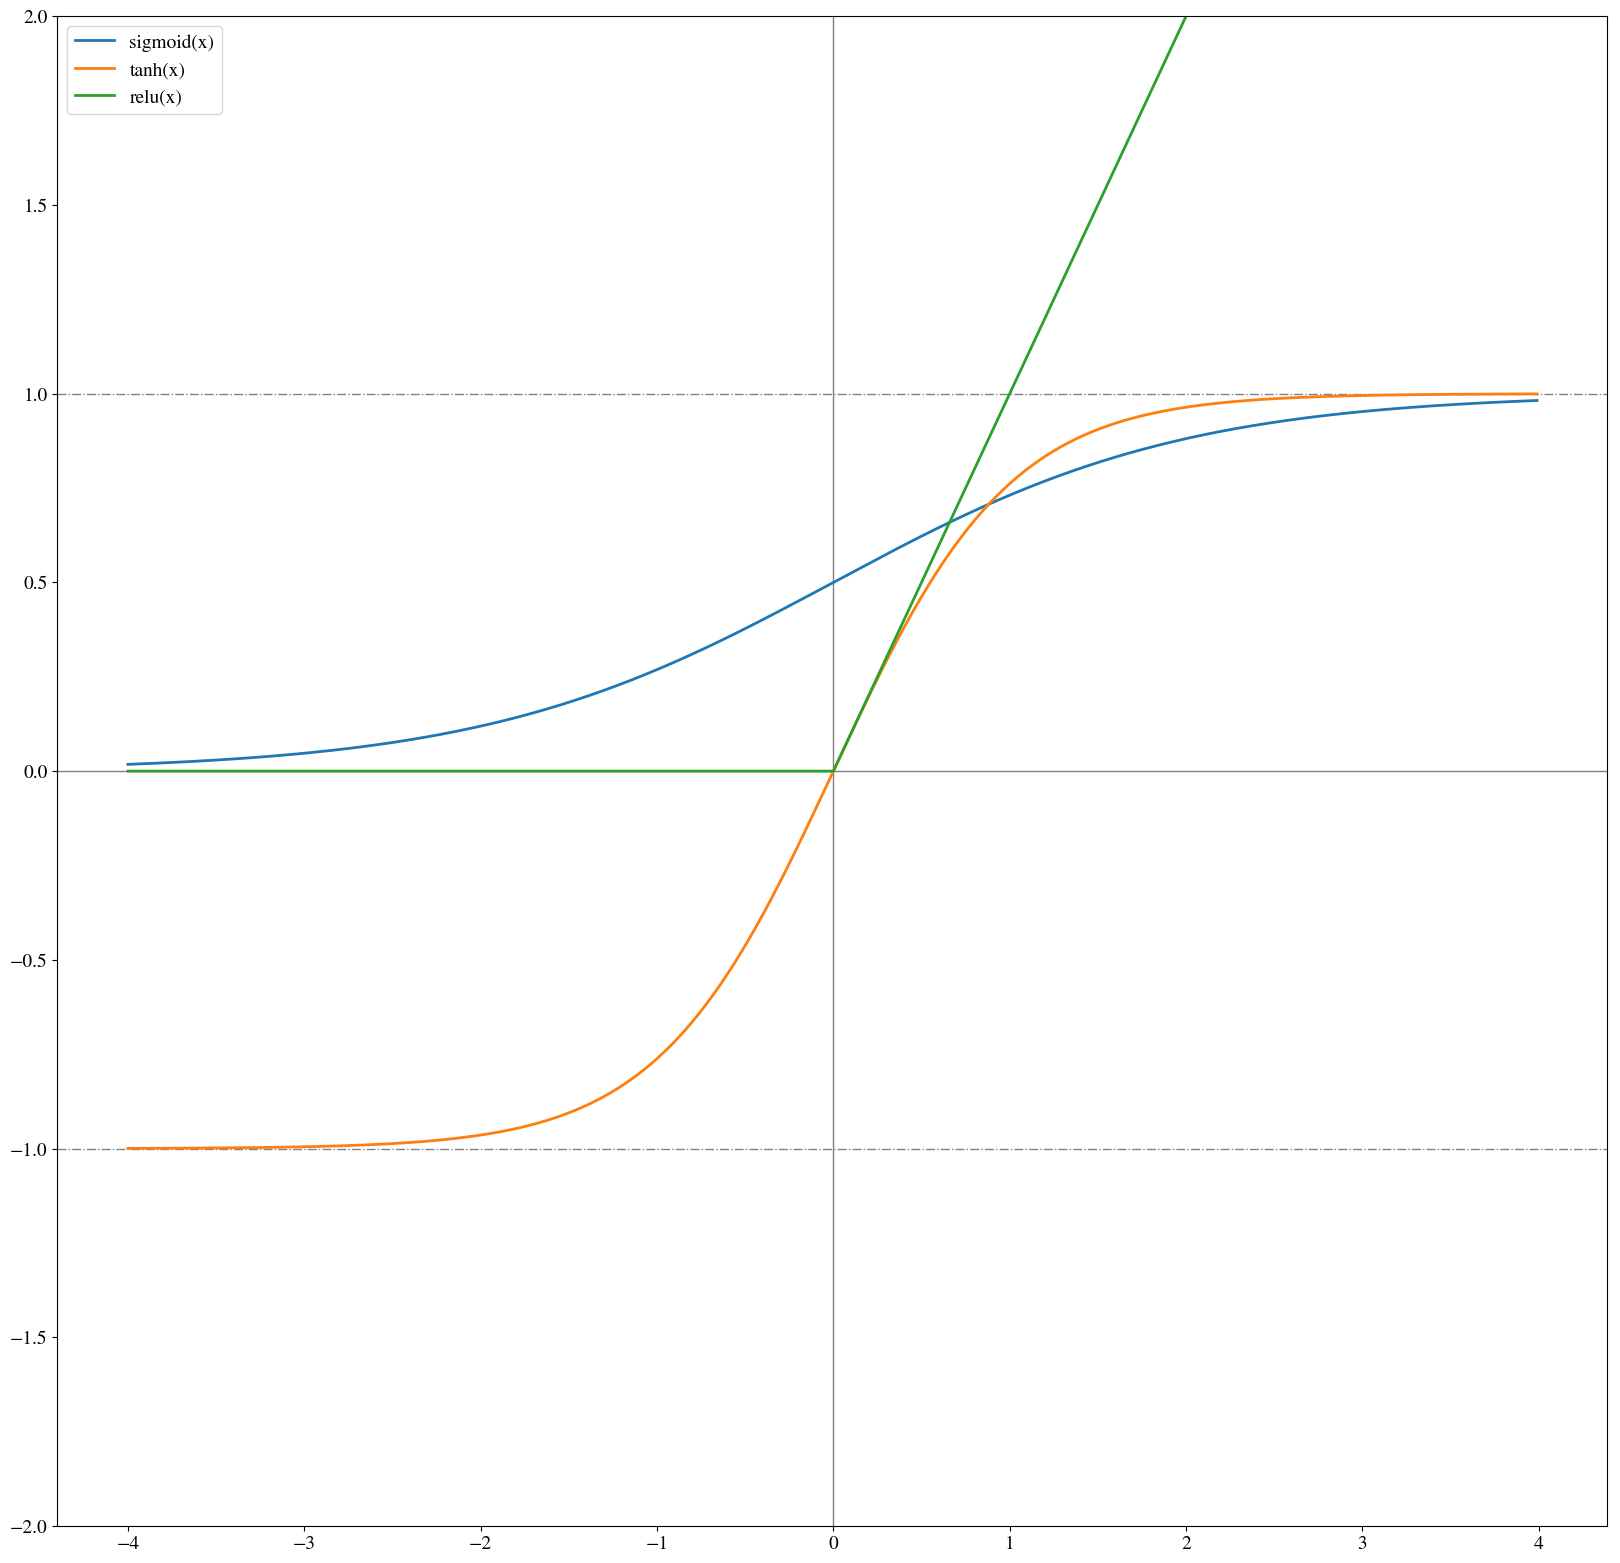

In [14]:
sigmoid = lambda t: 1 / (1 + np.exp(-t))
tanh = lambda t: (np.exp(t) - np.exp(-t)) / (np.exp(t) + np.exp(-t))
relu = lambda t:  np.maximum(t,0.)
softmax = lambda t: np.exp(t) / np.sum((1 + np.exp(t)), axis=0)
x = np.arange(-4,4,0.01) 

plt.axhline(y=0, ls='-', lw=1, color='gray')
plt.axvline(x=0, ls='-', lw=1, color='gray')
plt.axhline(y=-1., ls='-.', lw=1, color='gray')
plt.axhline(y=1., ls='-.', lw=1, color='gray')
plt.plot(x, sigmoid(x), label="sigmoid(x)")
plt.plot(x, tanh(x), label="tanh(x)")
plt.plot(x, relu(x), label="relu(x)")
plt.legend(loc=2)
plt.ylim([-2,2])

_= plt.show()

We'll start off with createing a new model, which in Keras is done with [```Sequential```](https://keras.io/models/sequential/). Despite the name, we are not creating a Sequential network, but rather specifying the model sequentially. Once we have added all the elements to the model, then we'll choose an optimizer and compile it, before running fit to start the training.  In the convolutional layers, we need to make a choice in the activation function. 

In [15]:
K.clear_session()

model = models.Sequential(name='SimpleModel')

Then we add the convolutional layer

In [16]:
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), strides = (1, 1), activation='relu', 
                        name = 'conv1', input_shape=data_batch.shape[1:]))

And then add the pooling layer

In [17]:
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name='max_pool1'))

And then add both again to make the second layer

In [18]:
model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides = (1, 1), activation='relu', 
                        name = 'conv2', input_shape=data_batch.shape[1:]))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name='max_pool2'))

Then we flatten the output from this second convolutional layer and pass it to a fully connected layer

In [19]:
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu', name='fc1'))

And then lastly, we add a fully-connected layer which will output our single number to make the prediction

In [20]:
model.add(layers.Dense(1, activation='sigmoid', name='fc2'))

We can create an optimizer definition. Let's start with Nesterov momentum. We need to specify the learning rate, and the momentum decay rate.

In [21]:
sgd = optimizers.SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

Next we compile the model, specifying binary cross-entropy.  

The binary cross-entropy function combines both the softmax tranformation and the entropy calculation from the logit model.  *What is softmax?* If we think of ```logits``` providing an output of evidence for the respective classes, softmax is a normalized function that is used to transform these evidences to probabilities. 

$$ \textrm{softmax}(x_i) =  \frac{\exp{x_i}}{\sum_j \exp{x_j}} $$   

The resulting probabilities will be between $0$ and $1$ and will sum to $1$ across the classes. Using softmax, evidences which are large will give rise to probabilities close to $1$ (i.e a good prediction), and evidences that are small will yield probabilities close to $0$ (i.e a weak prediction). Cross entropy is used as a metric for the error of the classification. We could also achieve the same thing in separate steps the Keras [```softmax```](https://keras.io/activations/#softmax) activation function and then sum up the results, 
but since this is a pair of functions that are used often, TensorFlow has combined them into the [```binary_crossentropy```](https://keras.io/losses/#binary_crossentropy) loss function.

In [22]:
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

We can print out a summary of the model that we have just built, we see each layer, the number of parameters and the also (in the case of frozen layers, the split between trainable and non-trainable parameters.  Here we see that none are frozen. 

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 30, 30, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 26, 26, 64)        51264     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              11076608  
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 1025      
Total para

All that work! Let's run the model now.

In [24]:
# Fit the model

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard(write_graph=False)])

Epoch 1/15
100/100 [==============================] - 29s 290ms/step - loss: 0.6942 - acc: 0.5247 - val_loss: 0.6953 - val_acc: 0.5106
Epoch 2/15
100/100 [==============================] - 29s 286ms/step - loss: 0.6945 - acc: 0.5059 - val_loss: 0.6905 - val_acc: 0.5044
Epoch 3/15
100/100 [==============================] - 29s 294ms/step - loss: 0.6923 - acc: 0.5266 - val_loss: 0.6883 - val_acc: 0.5375
Epoch 4/15
100/100 [==============================] - 32s 318ms/step - loss: 0.6773 - acc: 0.5666 - val_loss: 0.6671 - val_acc: 0.6081
Epoch 5/15
100/100 [==============================] - 32s 316ms/step - loss: 0.6628 - acc: 0.6191 - val_loss: 0.6500 - val_acc: 0.6106
Epoch 6/15
100/100 [==============================] - 32s 316ms/step - loss: 0.6456 - acc: 0.6312 - val_loss: 0.6643 - val_acc: 0.5981
Epoch 7/15
100/100 [==============================] - 32s 320ms/step - loss: 0.6511 - acc: 0.6213 - val_loss: 0.6339 - val_acc: 0.6388
Epoch 8/15
100/100 [==============================] - 3

We also want to add the possibility to visualize the results with TensorBoard. The simplest way is to define an `tensorboard` variable and then reference it in a callback in the `fit` method.

Using TensorBoard to visualize the graph is very simple. You need to issue a bash command referencing the place where you told TensorFlow to save the session graph:  

    tensorboard --logdir=/tmp/tensorflowlogs

it should resond with:  

    starting tensorboard on port 6006  (6006 is goog upside-down)
    
Head to port http:127.0.0.1:6006 in your browser  and view the graph.

### Putting it together in a model method

We generally don't create networks step by step, but rather using a function to define the model. We'll do that now. 

Note that we can also import the methods that we want to use from the Keras API, so that we don't need to repeat the modules all the time. **Exceptionally I am putting these statements here - don't forget about them.** 

In [25]:
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential 
from keras.optimizers import Adam,RMSprop,SGD

In [26]:
K.clear_session()
 
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

def simple_model():

    model = Sequential(name='SimpleModel')
    model.add(Conv2D(32, (5, 5), activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), name='max_pool1'))
    model.add(Conv2D(64, (5, 5), activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), name='max_pool2'))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', name='fc1'))
    model.add(Dense(1, activation='sigmoid', name='fc2'))
    
    sgd = SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='binary_crossentropy',
                  #optimizer=optimizers.RMSprop(lr=1e-4),
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

cnn1 = simple_model()
cnn1.summary()

# Fit model

history = cnn1.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[tensorboard])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 30, 30, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 26, 26, 64)        51264     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              11076608  
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 1025      
Total para

<a id='five-layer'></a>

---   
- Step 3 -     
=================

Add capacity to the network
---------------

[back to top](#top)

---

We've just built a small convnet  but we would like to see how adding complexity changes the performance.
Let's repeat this general structure: the network will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers, but with two more `Conv2D` + `MaxPooling2D` stages.  The additional layers will augment the capacity of the network, and also further reduce the size of the feature maps before reaching the `Flatten` layer that flattens the input to the single `Dense` layer. Now, we start from inputs of size 64x64  end up with feature maps of size 7x7 right before the `Flatten` layer. We still have a network without any dropout, batch normalization or regularization.

Again, the depth of the feature maps is progressively increasing in the network from 32 to 128, while the size of the feature maps is decreasing.   


With the added complexity, we will also change the optimization function from Nesterov Momentum to RMSProp.

Lastly, I have added the function at the top of the notebook that lets TensorBoard print out both the training and validation accuracy.

TensorFlow's playground
--------------------

If you want to play around with looking at the effects of deep learning network architecture choices, have a look at TensorFlow's amazing [playground](http://playground.tensorflow.org/) where we can experiment with simple Deep Neural Networks and see the impact of adding capacity (layers), changing the learning rate or activation function, or adjusting the regularization method or parameter.  


There is also a [great blog](https://cloud.google.com/blog/big-data/2016/07/understanding-neural-networks-with-tensorflow-playground) to expliain how to use the playground.

In [27]:
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
K.clear_session()

def fivelayer_model():

    model = Sequential(name='FiveLayerModel')
    model.add(Conv2D(32, (3, 3), activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), name='max_pool1'))
    model.add(Conv2D(64, (3, 3), activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), name='max_pool2'))
    model.add(Conv2D(128, (3, 3), activation='relu', name = 'conv3'))
    model.add(MaxPooling2D((2, 2), name='max_pool3'))
    model.add(Conv2D(128, (3, 3), activation='relu', name = 'conv4'))
    model.add(MaxPooling2D((2, 2), name='max_pool4'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='fc1'))
    model.add(Dense(1, activation='sigmoid', name='fc2'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    return model

cnn2 = fivelayer_model()
cnn2.summary()

# Fit model
history = cnn2.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard(write_graph=True)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 62, 62, 32)        896       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 31, 31, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 14, 14, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 6, 6, 128)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 4, 4, 128)         147584    
__________

### *Important note:* 
#### Saving models and TensorFlow logs with model output will use up disk space.  This will result in an error in TensorFlow when it tries to write files or save. Be sure to clear out your directories when you no longer need the results (here /tmp/tensorflowmodels/  and /tmp/tensorflowlogs)

Momentum and Adam optimizer
-----------------


![minebuster](minebuster.jpg) 

#### Momentum algorithm:

1. $\textbf{m} \leftarrow \beta \textbf{m} + \eta \nabla_{\theta} J(\theta) $
2. $ \theta \leftarrow \theta - \textbf{m} $

The gradient is used as an *acceleration*, not as a *speed*.

#### Adam:
Adds the concept of exponential decay of the momentum vector - both by decaying the average of past gradients, but also the average of squared gradients

<a id='happy-house'></a>

---   
- Step 4 -     
=================

Less capacity, but with batch normalization
---------------


[back to top](#top)

---


Now we simplify the model a bit, but we add batch normalization and the amazing Adam optimizer. 

We show an alternative way of specifying the model, using the `Model` method. This model comes from an exercise called "Happy House" in the [Coursera Deep Learning](https://www.coursera.org/specializations/deep-learning) course on CNNs. You can easily find it in people's GitHub repos on the internet.


In [179]:
# The Happy House model from the Coursera Deep Learning CNN course exercise
K.clear_session()

def happy_model():
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(data_batch.shape[1:])

    # CONV -> BN -> RELU Block applied to X
    X = ZeroPadding2D((1, 1))(X_input)
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = ZeroPadding2D((1, 1))(X)
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2, 2), name='max_pool2')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = ZeroPadding2D((1, 1))(X)
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2, 2), name='max_pool3')(X)
    
    # FC
    X = Flatten()(X)
    X = Dense(1024, kernel_initializer='he_normal', activation='relu', name='fc1')(X)
    X = Dense(1, kernel_initializer='he_normal', activation='sigmoid', name='fc2')(X)

    model = Model(inputs=X_input, outputs=X, name='HappyModel')
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
    return model

cnn3 = happy_model()
cnn3.summary()

# Fit model
history = cnn3.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard(write_graph=True)])

You don't need to use TensorBoard to plot out the results. You could also use MatplotLib

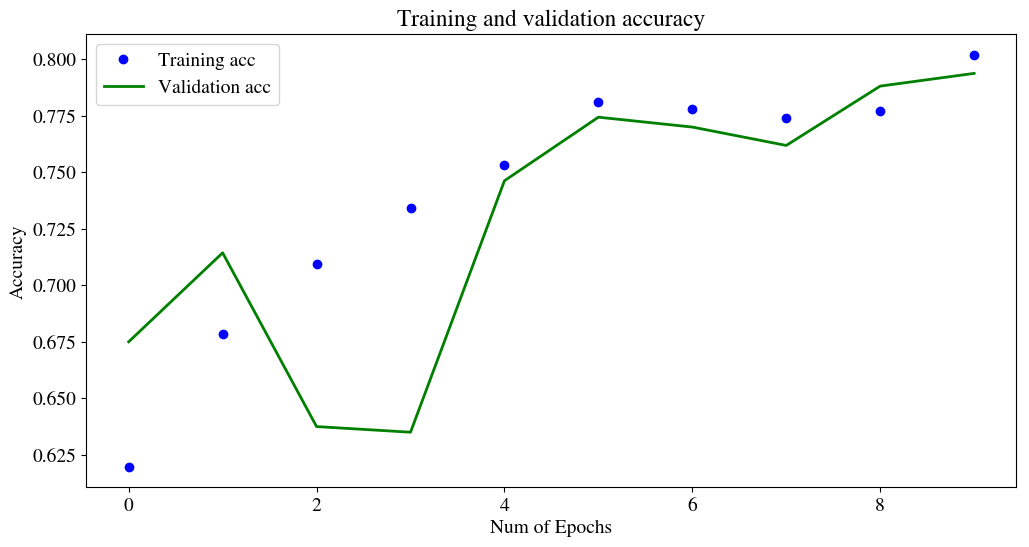

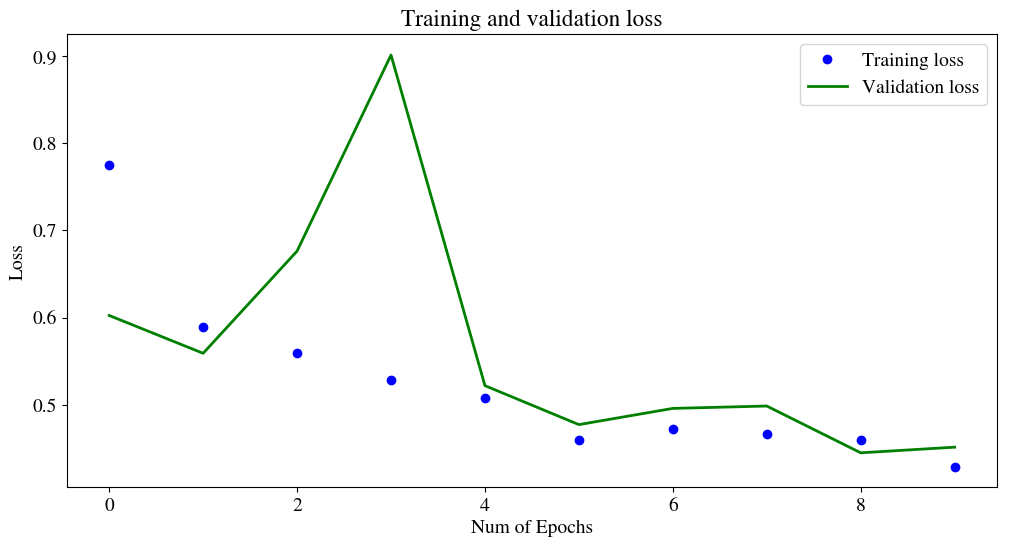

In [190]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g-', label='Validation acc')
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'g-', label='Validation loss')
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()

<a id='dropout'></a>

---   
- Step 5 -     
=================

Adding dropout
---------------


[back to top](#top)

---

We saw in Lecture how dropout works. Let's add it to the model to a network that looks like the very simple network that we started with. We will keep using the Adam optimizer too. We'll go back to using the `Sequential` method.



In [196]:
# A network architecture with BN and dropout
K.clear_session()

def dropout_model():

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3),
                     input_shape=data_batch.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(filters=128, kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(1, activation="sigmoid"))

    # Train model

    model.compile(Adam(lr=0.001),loss="binary_crossentropy", metrics=["accuracy"])
    return model

cnn4 = dropout_model()
cnn4.summary()

# Fit model
history = cnn4.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard(write_graph=True)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_18 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
activation_15 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 29, 29, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 29, 29, 64)        0         
__________

<a id='AlexNet'></a>

---   
- Step 6 -     
=================

---
The AlexNet Deep Learning architecture
----------------

[back to top](#top)

Finally, we will consider as an example the AlexNet model introduced in the paper by [Krizhevsky *et al.*](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) and applied there to the ImageNet 2010 contest. This will give some more experience in the use of convolutions, max pooling and dropout functions. 

Here are some images; the source is the paper and the "Hands on Machine Learning" book by Geron. 

![Alex2](ScreenAlex2.png)

![alex1](ScreenAlex1.png)

The AlexNet setup includes 5 layers of 2D convolutions followed by 3 dense fully connected layers. Each of the convolution layers has max pooling normalization and dropout to reduce overfitting. The pooling scheme includes overlapping, in that the pooling patch (3x3) is larger than the pooling stride (2 units). The dropout rate has a keep probability of 80% - i.e. dropout probability of 20% - for all the convolution layers. The model also includes weight decay for all layers with a multiplier of 0.0005. However we won't use that in the example (left as an exercise, using L2 regularizers).
Have a look [here at the TensorFlow docs](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/l2_regularizer) and here in the [Kearas docs](https://keras.io/regularizers/#example)

Since our 64x64 images are smaller than the 256x256 images of ImageNet, you might consider only 3 2D convolutions instead of 5. You can also modify the batch size and reduce the convolution patch sizes from 5x5 to 3x3. Otherwise, the model is the same as AlexNet. It can serve as a useful benchmark for image classification. However, since it was designed for GPUs, running a large number of epochs will take a long time on CPUs.

I took this code from [here](https://www.mydatahack.com/building-alexnet-with-keras/) but I haven't really played around with it. That might be another exercise for you.

---

In [205]:
# An AlexNet network architecture
K.clear_session()

def alex_model():
    # (3) Create a sequential model
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=data_batch.shape[1:], kernel_size=(11,11),\
     strides=(4,4), padding='same'))
    model.add(Activation('relu'))
    # Pooling 
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Passing it to a dense layer
    model.add(Flatten())
    # 1st Dense Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Dense Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))


    # (4) Compile 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model 

cnn5 = alex_model()
cnn5.summary()


# Fit model
history = cnn5.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard(write_graph=True)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 96)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 96)          384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         614656    
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 256)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0         
__________


<a id='data-augmentation'></a>

---   
- Step 7 -     
=================

---
Using Data Augmentation 
=======

[back to top](#top)


From the Chollet notebook:

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. 

In [207]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './all/train'

# Directories for our training,
directories = []

# The directory where we will
# store our smaller dataset
base_dir = './cats_and_dogs_small'
directories.append(base_dir)

# validation and test splits
train_dir = os.path.join(base_dir, 'train')
directories.append(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
directories.append(validation_dir)

test_dir = os.path.join(base_dir, 'test')
directories.append(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
directories.append(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
directories.append(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
directories.append(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
directories.append(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
directories.append(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
directories.append(test_dogs_dir)

# if they have not already been created
for dir in directories: 
    os.mkdir(dir)

In [208]:
# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)

Let's check how many images there are in each directory of the split (train/validation/test):

In [209]:
for dir in directories[4:]:
    print("\nImages in " + dir + ":" + str(len(os.listdir(dir))))


Images in ./cats_and_dogs_small/train/cats:1000

Images in ./cats_and_dogs_small/train/dogs:1000

Images in ./cats_and_dogs_small/validation/cats:500

Images in ./cats_and_dogs_small/validation/dogs:500

Images in ./cats_and_dogs_small/test/cats:500

Images in ./cats_and_dogs_small/test/dogs:500


In [210]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

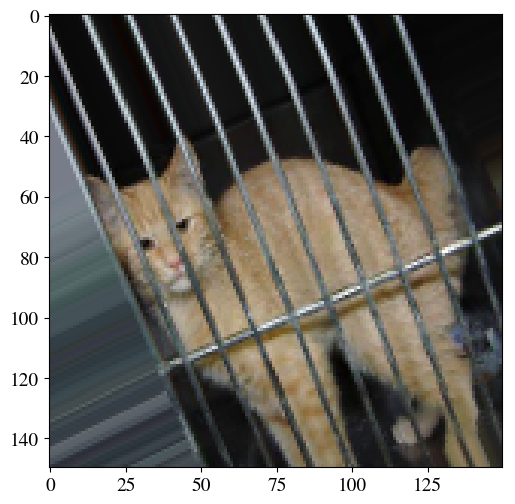

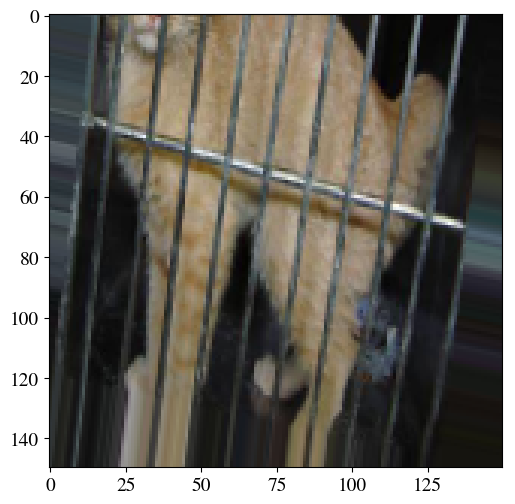

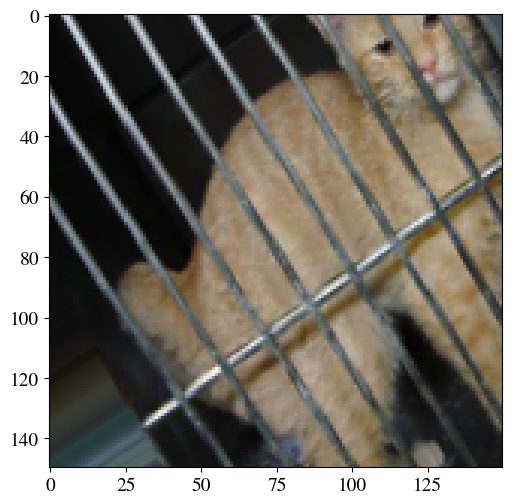

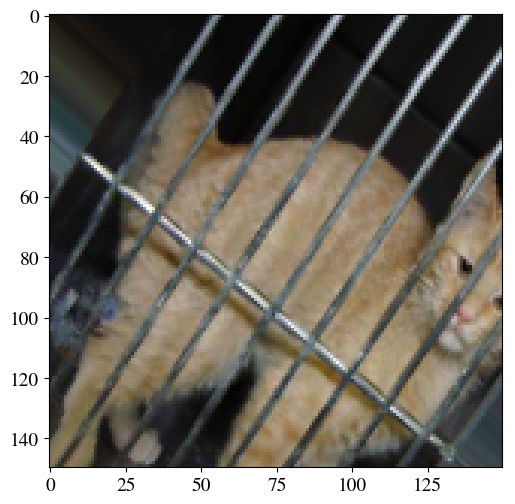

In [211]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [212]:
# A network architecture with BN and dropout
K.clear_session()

def dataaug_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu',
                            input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Train model

    model.compile(Adam(lr=0.001),loss="binary_crossentropy", metrics=["accuracy"])
    return model

cnn6 = dataaug_model()
cnn6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [213]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 64x64
        target_size=(64, 64),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

history = cnn6.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard(write_graph=True)])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 18s 178ms/step - loss: 0.7012 - acc: 0.5141 - val_loss: 0.6945 - val_acc: 0.5108
Epoch 2/10
100/100 [==============================] - 17s 165ms/step - loss: 0.6845 - acc: 0.5288 - val_loss: 0.6724 - val_acc: 0.5774
Epoch 3/10
100/100 [==============================] - 17s 166ms/step - loss: 0.6852 - acc: 0.5069 - val_loss: 0.6870 - val_acc: 0.5558
Epoch 4/10
100/100 [==============================] - 17s 166ms/step - loss: 0.6879 - acc: 0.5281 - val_loss: 0.6853 - val_acc: 0.4981
Epoch 5/10
100/100 [==============================] - 16s 162ms/step - loss: 0.6861 - acc: 0.5459 - val_loss: 0.6756 - val_acc: 0.5799
Epoch 6/10
100/100 [==============================] - 18s 178ms/step - loss: 0.6812 - acc: 0.5547 - val_loss: 0.6907 - val_acc: 0.5203
Epoch 7/10
100/100 [==============================] - 17s 166ms/step - loss: 0.6871 - acc: 0.5397 - val_lo

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>